<a href="https://colab.research.google.com/github/Shrinjita/Reinforcement-Learning-Techniques/blob/main/Reinforcement_Learning_in_FrozenLake_v1_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning for FrozenLake-v1 Environment
This notebook implements and compares four reinforcement learning algorithms on the FrozenLake-v1 environment:
1. Q-Learning (tabular)
2. SARSA (tabular)
3. Deep Q-Network (DQN)
4. Proximal Policy Optimization (PPO)

We'll analyze how performance improves with increasing algorithm complexity.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import pandas as pd
import random
from collections import deque
import os
import seaborn as sns
from tqdm.notebook import tqdm

# For DQN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For PPO (simplified implementation)
import torch.distributions as distributions

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## 1. Environment Setup

In [ ]:
def create_environment(render_mode=None):
    """
    Create the FrozenLake-v1 environment.

    Args:
        render_mode: The rendering mode for the environment

    Returns:
        gym environment
    """
    env = gym.make('FrozenLake-v1', is_slippery=True, render_mode=render_mode)
    return env

In [ ]:
def analyze_environment(env):
    """
    Analyze and print information about the environment.

    Args:
        env: The gym environment
    """
    print(f"State space: {env.observation_space}")
    print(f"Action space: {env.action_space}")

    # For FrozenLake, explain the actions
    print("\nActions:")
    print("0: LEFT")
    print("1: DOWN")
    print("2: RIGHT")
    print("3: UP")

    # Explain the environment
    print("\nEnvironment Description:")
    print("S: Starting point")
    print("F: Frozen surface (safe)")
    print("H: Hole (game over)")
    print("G: Goal")
    print("\nThe agent must navigate from S to G without falling into H.")
    print("The environment is slippery, so actions may not always result in the intended direction.")

# Initialize and analyze the environment
env = create_environment()
analyze_environment(env)

State space: Discrete(16)
Action space: Discrete(4)

Actions:
0: LEFT
1: DOWN
2: RIGHT
3: UP

Environment Description:
S: Starting point
F: Frozen surface (safe)
H: Hole (game over)
G: Goal

The agent must navigate from S to G without falling into H.
The environment is slippery, so actions may not always result in the intended direction.


## 2. Q-Learning Implementation

Q-Learning is an off-policy temporal difference learning algorithm that directly approximates the optimal action-value function.

In [ ]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        """
        Initialize a Q-Learning agent.

        Args:
            state_size: Size of the state space
            action_size: Size of the action space
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            epsilon_start: Starting value of epsilon for epsilon-greedy policy
            epsilon_end: Minimum value of epsilon
            epsilon_decay: Decay rate of epsilon per episode
        """
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_size, action_size))

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy.

        Args:
            state: Current state

        Returns:
            Selected action
        """
        if np.random.rand() < self.epsilon:
            # Exploration: choose a random action
            return np.random.randint(self.action_size)
        else:
            # Exploitation: choose the best action based on Q-values
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        """
        Update Q-table using the Q-learning update rule.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether the episode is done
        """
        # Q-Learning update formula:
        # Q(s,a) = Q(s,a) + α * [r + γ * max_a' Q(s',a') - Q(s,a)]

        # Calculate the target Q-value
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[next_state])

        # Calculate the TD error
        td_error = target - self.q_table[state, action]

        # Update the Q-value
        self.q_table[state, action] += self.lr * td_error

    def decay_epsilon(self):
        """
        Decay epsilon for epsilon-greedy policy.
        """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

In [ ]:
def train_q_learning(env, agent, episodes=2000, max_steps=100):
    """
    Train a Q-Learning agent.

    Args:
        env: The gym environment
        agent: The Q-Learning agent
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode

    Returns:
        rewards: List of rewards per episode
        steps: List of steps per episode
        success_rate: List of success rates (moving average)
    """
    rewards = []
    steps = []
    success_rate = []
    successes = 0

    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0

        for step in range(max_steps):
            # Select action
            action = agent.select_action(state)

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update Q-table
            agent.update(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward
            episode_steps += 1

            if done:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Record metrics
        rewards.append(episode_reward)
        steps.append(episode_steps)

        # Update success rate (moving average of last 100 episodes)
        if reward > 0:  # In FrozenLake, reward > 0 means success
            successes += 1
        if episode >= 100:
            if rewards[episode - 100] > 0:
                successes -= 1

        if episode < 100:
            success_rate.append(successes / (episode + 1))
        else:
            success_rate.append(successes / 100)

    return rewards, steps, success_rate

In [ ]:
def visualize_q_learning_results(rewards, steps, success_rate):
    """
    Visualize the results of Q-Learning training.

    Args:
        rewards: List of rewards per episode
        steps: List of steps per episode
        success_rate: List of success rates (moving average)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot rewards
    axes[0].plot(rewards, alpha=0.2, color='blue')
    axes[0].plot(pd.Series(rewards).rolling(100).mean(), color='blue')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].set_title('Rewards over Episodes')
    axes[0].grid(True)

    # Plot steps
    axes[1].plot(steps, alpha=0.2, color='green')
    axes[1].plot(pd.Series(steps).rolling(100).mean(), color='green')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Steps')
    axes[1].set_title('Steps per Episode')
    axes[1].grid(True)

    # Plot success rate
    axes[2].plot(success_rate, color='red')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Success Rate')
    axes[2].set_title('Success Rate (Moving Average)')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

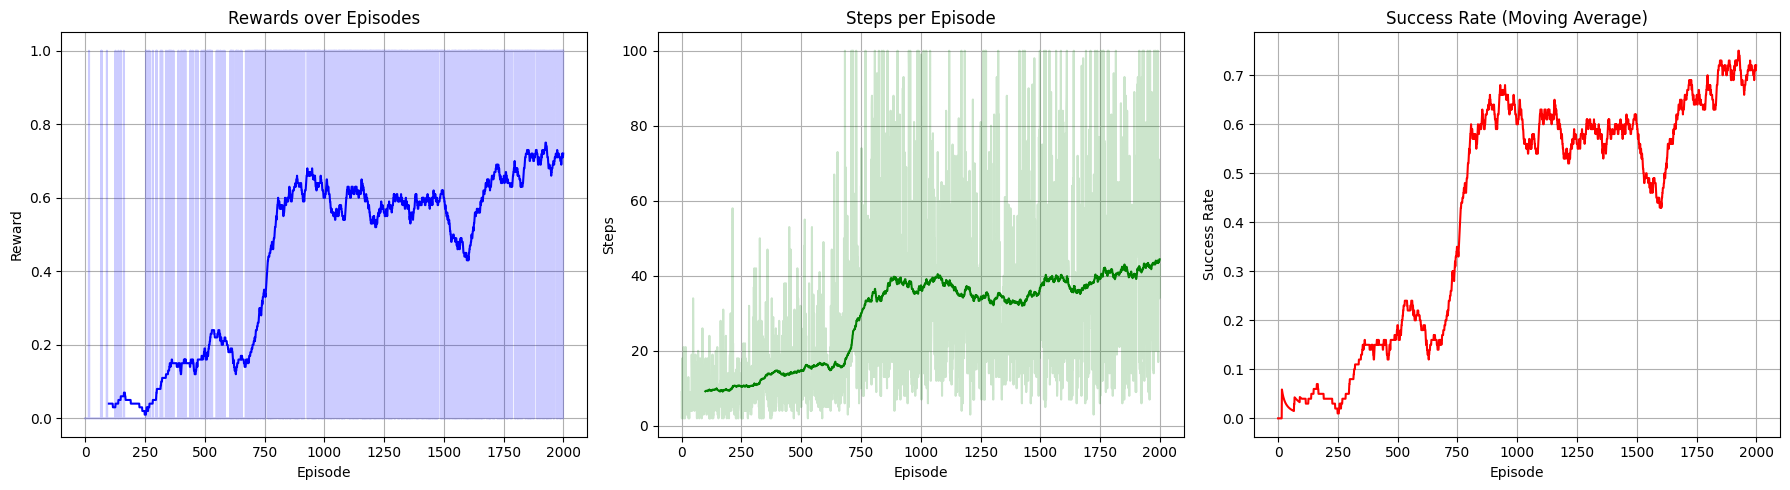

In [ ]:
# Visualize results
visualize_q_learning_results(q_rewards, q_steps, q_success_rate)

In [ ]:
def visualize_q_table(q_table):
    """
    Visualize the Q-table.

    Args:
        q_table: The Q-table to visualize
    """
    # Reshape Q-table for visualization
    # For FrozenLake 4x4, there are 16 states
    q_values = np.max(q_table, axis=1).reshape(4, 4)

    plt.figure(figsize=(8, 6))
    sns.heatmap(q_values, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Max Q-Values for Each State')
    plt.xlabel('Column')
    plt.ylabel('Row')
    #plt.savefig('plots/q_table_visualization.png')
    plt.show()

    # Visualize the policy
    policy = np.argmax(q_table, axis=1).reshape(4, 4)

    # Convert action indices to arrows
    action_symbols = ['←', '↓', '→', '↑']
    policy_symbols = np.array([[action_symbols[action] for action in row] for row in policy])

    plt.figure(figsize=(8, 6))
    sns.heatmap(policy.astype(float), annot=policy_symbols, fmt='', cmap='viridis', cbar=False)
    plt.title('Learned Policy')
    plt.xlabel('Column')
    plt.ylabel('Row')
   # plt.savefig('/content/drive/MyDrive/Colab Notebooks/RLT APP DEV/plots/q_learning_policy.png')
    plt.show()

# Initialize Q-Learning agent and environment
q_env = create_environment()
q_agent = QLearningAgent(q_env.observation_space.n, q_env.action_space.n)

# Train the agent
q_rewards, q_steps, q_success_rate = train_q_learning(q_env, q_agent)

  0%|          | 0/2000 [00:00<?, ?it/s]

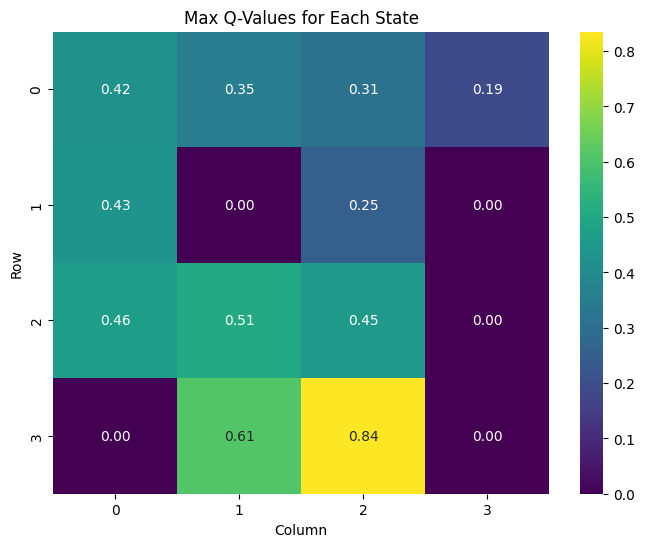

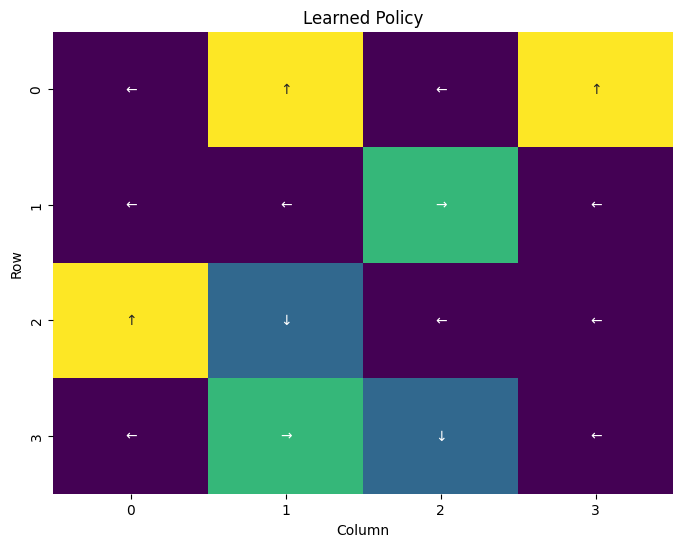

In [ ]:
visualize_q_table(q_agent.q_table)

## 3. SARSA Implementation

SARSA (State-Action-Reward-State-Action) is an on-policy temporal difference learning algorithm.

In [ ]:
class SarsaAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        """
        Initialize a SARSA agent.

        Args:
            state_size: Size of the state space
            action_size: Size of the action space
            learning_rate: Learning rate (alpha)
            discount_factor: Discount factor (gamma)
            epsilon_start: Starting value of epsilon for epsilon-greedy policy
            epsilon_end: Minimum value of epsilon
            epsilon_decay: Decay rate of epsilon per episode
        """
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_size, action_size))

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy.

        Args:
            state: Current state

        Returns:
            Selected action
        """
        if np.random.rand() < self.epsilon:
            # Exploration: choose a random action
            return np.random.randint(self.action_size)
        else:
            # Exploitation: choose the best action based on Q-values
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, next_action, done):
        """
        Update Q-table using the SARSA update rule.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            next_action: Next action to be taken
            done: Whether the episode is done
        """
        # SARSA update formula:
        # Q(s,a) = Q(s,a) + α * [r + γ * Q(s',a') - Q(s,a)]

        # Calculate the target Q-value
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.q_table[next_state, next_action]

        # Calculate the TD error
        td_error = target - self.q_table[state, action]

        # Update the Q-value
        self.q_table[state, action] += self.lr * td_error

    def decay_epsilon(self):
        """
        Decay epsilon for epsilon-greedy policy.
        """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

def train_sarsa(env, agent, episodes=2000, max_steps=100):
    """
    Train a SARSA agent.

    Args:
        env: The gym environment
        agent: The SARSA agent
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode

    Returns:
        rewards: List of rewards per episode
        steps: List of steps per episode
        success_rate: List of success rates (moving average)
    """
    rewards = []
    steps = []
    success_rate = []
    successes = 0

    for episode in tqdm(range(episodes)):
        state, _ = env.reset()

        # Select first action
        action = agent.select_action(state)

        episode_reward = 0
        episode_steps = 0

        for step in range(max_steps):
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Select next action
            next_action = agent.select_action(next_state)

            # Update Q-table
            agent.update(state, action, reward, next_state, next_action, done)

            state = next_state
            action = next_action
            episode_reward += reward
            episode_steps += 1

            if done:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Record metrics
        rewards.append(episode_reward)
        steps.append(episode_steps)

        # Update success rate (moving average of last 100 episodes)
        if reward > 0:  # In FrozenLake, reward > 0 means success
            successes += 1
        if episode >= 100:
            if rewards[episode - 100] > 0:
                successes -= 1

        if episode < 100:
            success_rate.append(successes / (episode + 1))
        else:
            success_rate.append(successes / 100)

    return rewards, steps, success_rate

def visualize_sarsa_results(rewards, steps, success_rate):
    """
    Visualize the results of SARSA training.

    Args:
        rewards: List of rewards per episode
        steps: List of steps per episode
        success_rate: List of success rates (moving average)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot rewards
    axes[0].plot(rewards, alpha=0.2, color='blue')
    axes[0].plot(pd.Series(rewards).rolling(100).mean(), color='blue')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].set_title('Rewards over Episodes')
    axes[0].grid(True)

    # Plot steps
    axes[1].plot(steps, alpha=0.2, color='green')
    axes[1].plot(pd.Series(steps).rolling(100).mean(), color='green')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Steps')
    axes[1].set_title('Steps per Episode')
    axes[1].grid(True)

    # Plot success rate
    axes[2].plot(success_rate, color='red')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Success Rate')
    axes[2].set_title('Success Rate (Moving Average)')
    axes[2].grid(True)

    plt.tight_layout()
   # plt.savefig('plots/sarsa_results.png')
    plt.show()

In [ ]:
def visualize_sarsa_table(q_table):
    """
    Visualize the SARSA Q-table.

    Args:
        q_table: The Q-table to visualize
    """
    # Reshape Q-table for visualization
    q_values = np.max(q_table, axis=1).reshape(4, 4)

    plt.figure(figsize=(8, 6))
    sns.heatmap(q_values, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Max Q-Values for Each State (SARSA)')
    plt.xlabel('Column')
    plt.ylabel('Row')
    #plt.savefig('plots/sarsa_table_visualization.png')
    plt.show()

    # Visualize the policy
    policy = np.argmax(q_table, axis=1).reshape(4, 4)

    # Convert action indices to arrows
    action_symbols = ['←', '↓', '→', '↑']
    policy_symbols = np.array([[action_symbols[action] for action in row] for row in policy])

    plt.figure(figsize=(8, 6))
    sns.heatmap(policy.astype(float), annot=policy_symbols, fmt='', cmap='viridis', cbar=False)
    plt.title('Learned Policy (SARSA)')
    plt.xlabel('Column')
    plt.ylabel('Row')
    #plt.savefig('plots/sarsa_policy.png')
    plt.show()

# Initialize SARSA agent and environment
sarsa_env = create_environment()
sarsa_agent = SarsaAgent(sarsa_env.observation_space.n, sarsa_env.action_space.n)

# Train the agent
sarsa_rewards, sarsa_steps, sarsa_success_rate = train_sarsa(sarsa_env, sarsa_agent)

  0%|          | 0/2000 [00:00<?, ?it/s]

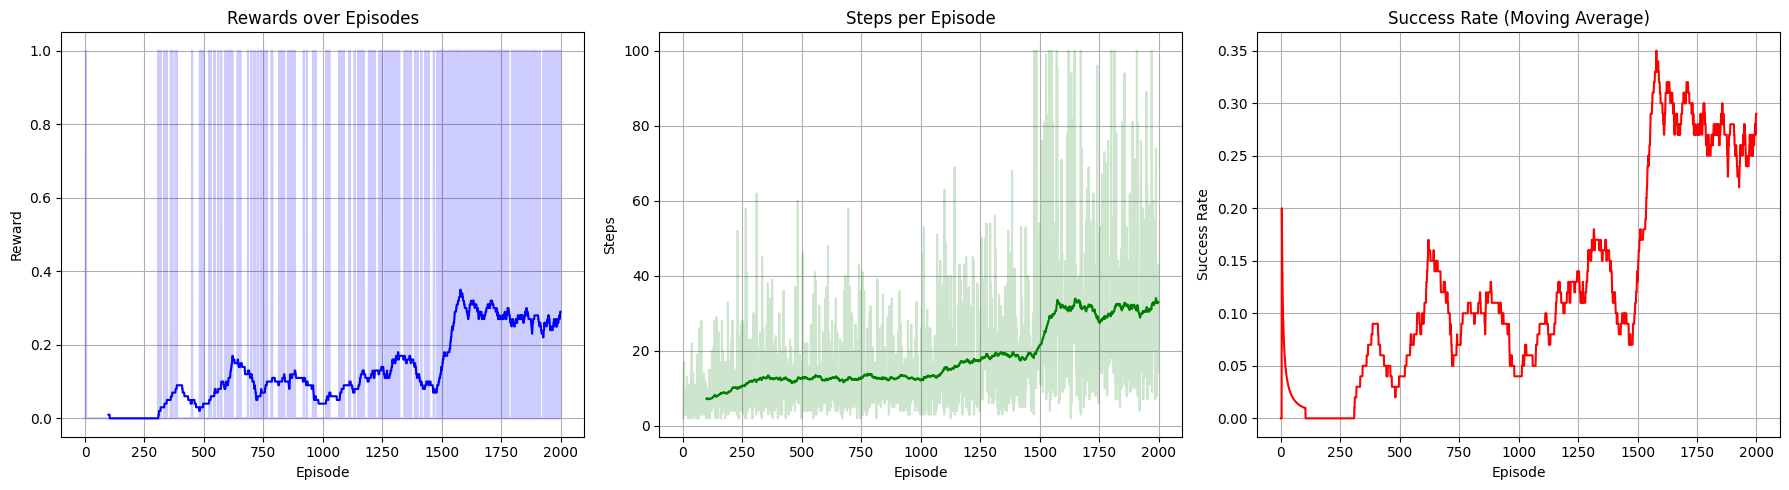

In [ ]:
# Visualize results
visualize_sarsa_results(sarsa_rewards, sarsa_steps, sarsa_success_rate)

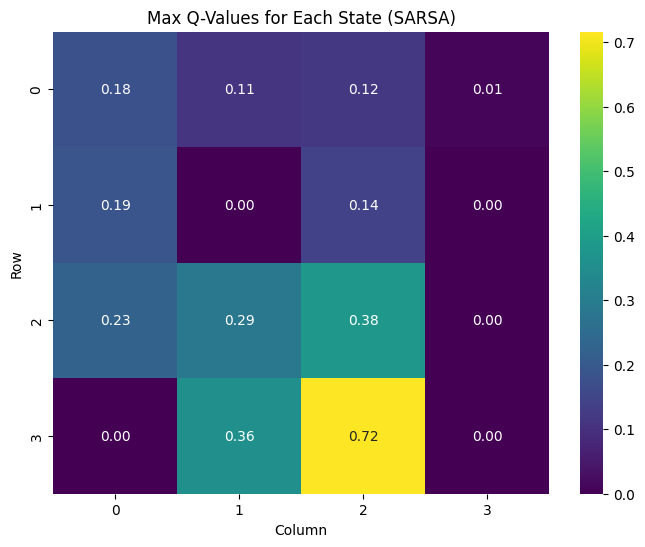

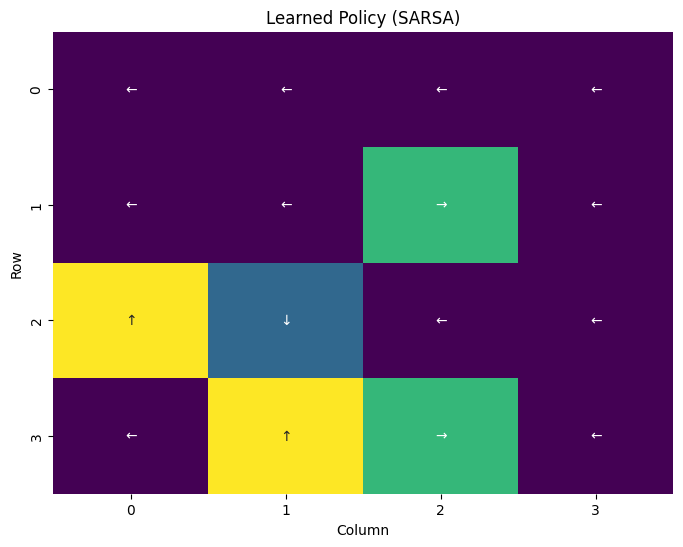

In [ ]:
visualize_sarsa_table(sarsa_agent.q_table)

## 4. Deep Q-Network (DQN) Implementation

DQN uses a neural network to approximate the Q-function, which allows it to handle larger state spaces.

In [ ]:

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        """
        Initialize a Q-Network.

        Args:
            state_size: Size of the state space
            action_size: Size of the action space
            hidden_size: Size of the hidden layer
        """
        super(QNetwork, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor

        Returns:
            Q-values for each action
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        """
        Initialize a replay buffer.

        Args:
            capacity: Maximum capacity of the buffer
        """
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether the episode is done
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample a batch of transitions from the buffer.

        Args:
            batch_size: Size of the batch

        Returns:
            Batch of transitions
        """
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """
        Get the current size of the buffer.

        Returns:
            Current size of the buffer
        """
        return len(self.buffer)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_capacity=10000, batch_size=64, update_target_every=100):
        """
        Initialize a DQN agent.

        Args:
            state_size: Size of the state space
            action_size: Size of the action space
            learning_rate: Learning rate
            discount_factor: Discount factor (gamma)
            epsilon_start: Starting value of epsilon for epsilon-greedy policy
            epsilon_end: Minimum value of epsilon
            epsilon_decay: Decay rate of epsilon per episode
            buffer_capacity: Capacity of the replay buffer
            batch_size: Batch size for training
            update_target_every: Number of steps between target network updates
        """
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_target_every = update_target_every
        self.steps = 0

        # Initialize Q-networks
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)

        # Copy parameters from Q-network to target network
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()  # Set target network to evaluation mode

        # Initialize optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Initialize replay buffer
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy.

        Args:
            state: Current state

        Returns:
            Selected action
        """
        if np.random.rand() < self.epsilon:
            # Exploration: choose a random action
            return np.random.randint(self.action_size)
        else:
            # Exploitation: choose the best action based on Q-values
            state_tensor = torch.FloatTensor(self.state_one_hot(state)).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def state_one_hot(self, state):
        """
        Convert state to one-hot encoding.

        Args:
            state: State to convert

        Returns:
            One-hot encoded state
        """
        one_hot = np.zeros(self.state_size)
        one_hot[state] = 1.0
        return one_hot

    def update(self, state, action, reward, next_state, done):
        """
        Update the agent's knowledge.

        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether the episode is done
        """
        # Add transition to replay buffer
        self.replay_buffer.add(self.state_one_hot(state), action, reward, self.state_one_hot(next_state), done)

        # Increment step counter
        self.steps += 1

        # If there are enough samples in the buffer, perform update
        if len(self.replay_buffer) >= self.batch_size:
            self.learn()

        # Update target network periodically
        if self.steps % self.update_target_every == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def learn(self):
        """
        Perform learning update.
        """
        # Sample a batch of transitions from the replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Compute current Q-values
        current_q = self.q_network(states).gather(1, actions)

        # Compute next Q-values
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1, keepdim=True)[0]

        # Compute target Q-values
        target_q = rewards + self.gamma * next_q * (1 - dones)

        # Compute loss
        loss = F.mse_loss(current_q, target_q)

        # Update parameters
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def decay_epsilon(self):
        """
        Decay epsilon for epsilon-greedy policy.
        """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

In [ ]:
def train_dqn(env, agent, episodes=2000, max_steps=100):
    """
    Train a DQN agent.

    Args:
        env: The gym environment
        agent: The DQN agent
        episodes: Number of episodes to train
        max_steps: Maximum steps per episode

    Returns:
        rewards: List of rewards per episode
        steps: List of steps per episode
        success_rate: List of success rates (moving average)
        losses: List of losses per episode
    """
    rewards = []
    steps = []
    success_rate = []
    losses = []
    successes = 0

    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0
        episode_losses = []

        for step in range(max_steps):
            # Select action
            action = agent.select_action(state)

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update agent's knowledge
            loss = agent.update(state, action, reward, next_state, done)
            if loss is not None:
                episode_losses.append(loss)

            state = next_state
            episode_reward += reward
            episode_steps += 1

            if done:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Record metrics
        rewards.append(episode_reward)
        steps.append(episode_steps)

        # Update success rate (moving average of last 100 episodes)
        if reward > 0:  # In FrozenLake, reward > 0 means success
            successes += 1
        if episode >= 100:
            if rewards[episode - 100] > 0:
                successes -= 1

        if episode < 100:
            success_rate.append(successes / (episode + 1))
        else:
            success_rate.append(successes / 100)

        # Record losses
        losses.append(np.mean(episode_losses) if episode_losses else 0)

    return rewards, steps, success_rate, losses

def evaluate_dqn(env, agent, episodes=100):
    """
    Evaluate a DQN agent.

    Args:
        env: The gym environment
        agent: The DQN agent
        episodes: Number of episodes to evaluate

    Returns:
        success_rate: Success rate
    """
    successes = 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            # Select action (without exploration)
            state_tensor = torch.FloatTensor(agent.state_one_hot(state)).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = agent.q_network(state_tensor)
            action = q_values.argmax().item()

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            state = next_state

            if done and reward > 0:  # In FrozenLake, reward > 0 means success
                successes += 1
                break

    return successes / episodes

def visualize_dqn_results(rewards, steps, success_rate, losses):
    """
    Visualize the results of DQN training.

    Args:
        rewards: List of rewards per episode
        steps: List of steps per episode
        success_rate: List of success rates (moving average)
        losses: List of losses per episode
    """
    plt.figure(figsize=(15, 10))

    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(rewards, alpha=0.2, color='blue')
    plt.plot(pd.Series(rewards).rolling(100).mean(), color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards over Episodes')
    plt.grid(True)

    # Plot steps
    plt.subplot(2, 2, 2)
    plt.plot(steps, alpha=0.2, color='green')
    plt.plot(pd.Series(steps).rolling(100).mean(), color='green')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps per Episode')
    plt.grid(True)

    # Plot success rate
    plt.subplot(2, 2, 3)
    plt.plot(success_rate, color='red')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.title('Success Rate (Moving Average)')
    plt.grid(True)

    # Plot losses
    if losses:
        plt.subplot(2, 2, 4)
        plt.plot(losses, alpha=0.2, color='purple')
        plt.plot(pd.Series(losses).rolling(100).mean(), color='purple')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True)

    plt.tight_layout()
    plt.show()



Training agent...


  0%|          | 0/2000 [00:00<?, ?it/s]

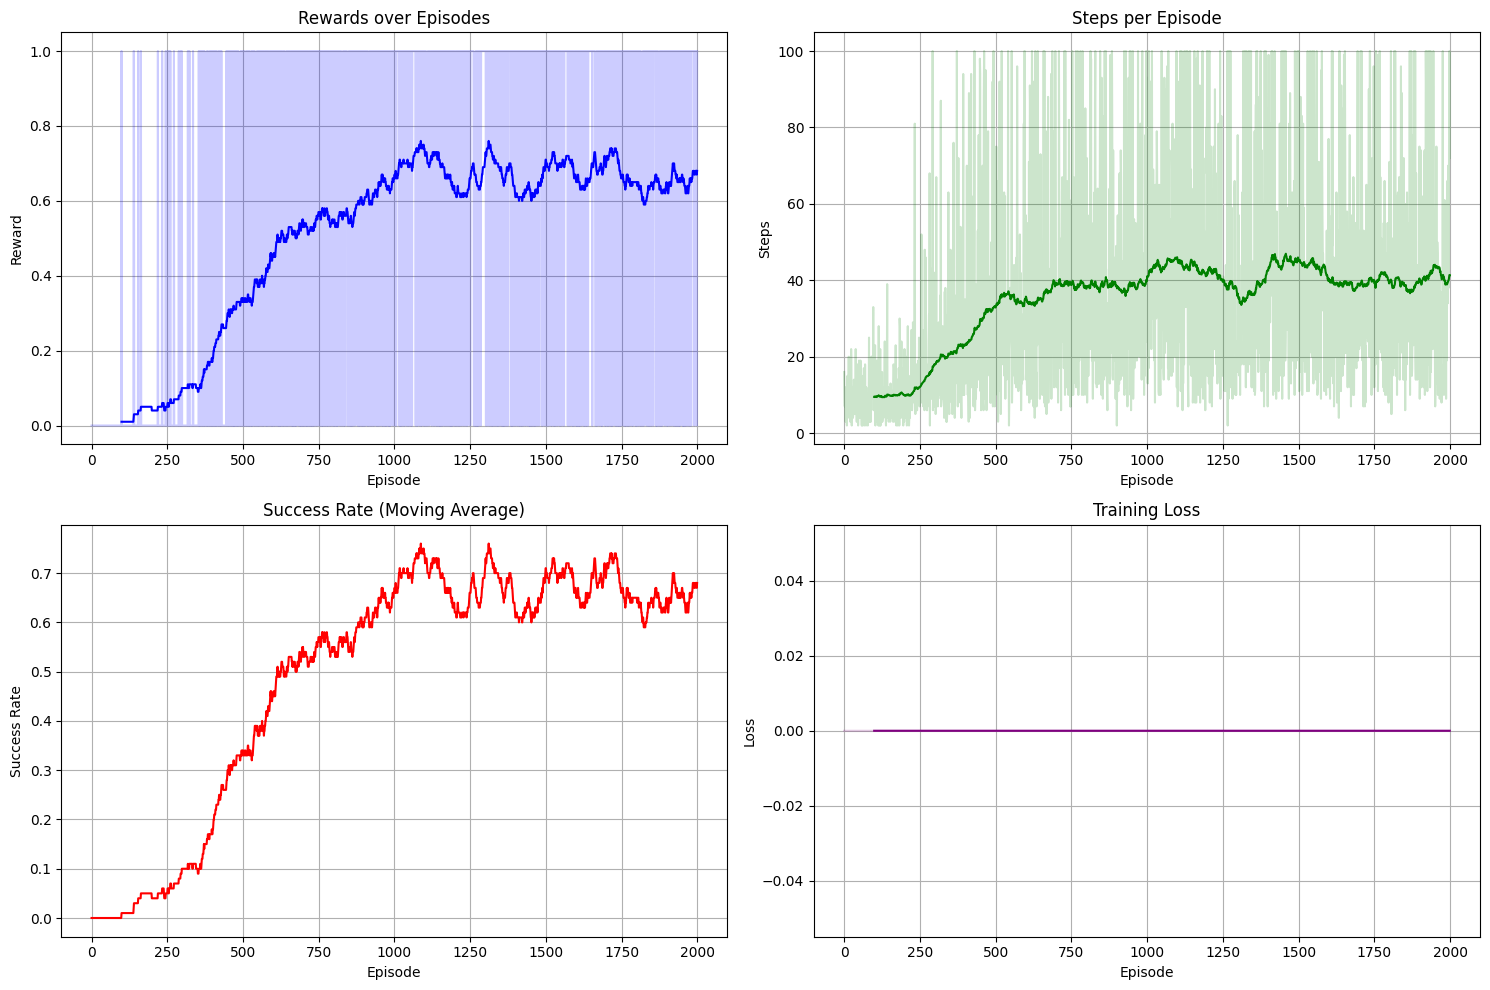

Evaluating agent...


TypeError: unsupported format string passed to list.__format__

In [ ]:
# Main execution code
if __name__ == "__main__":
    # Create environment
    env = gym.make("FrozenLake-v1", is_slippery=True)

    # Initialize agent
    state_size = env.observation_space.n
    action_size = env.action_space.n

    agent = DQNAgent(
        state_size=state_size,
        action_size=action_size,
        learning_rate=0.001,
        discount_factor=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        buffer_capacity=10000,
        batch_size=64,
        update_target_every=100
    )

    # Train agent
    print("Training agent...")
    rewards, steps, success_rate, losses = train_dqn(
        env=env,
        agent=agent,
        episodes=2000,
        max_steps=100
    )
        # Visualize results
    visualize_dqn_results(rewards, steps, success_rate, losses)

    # Evaluate agent
    print("Evaluating agent...")
    dqn_success_rate = evaluate_dqn(env, agent, episodes=100)

In [ ]:
    print(f"Success rate: {dqn_success_rate:.2f}")

Success rate: 0.70
